In [1]:
import tensorflow as tf

In [2]:
# Adaptations for running Tensorflow on GeForce RTX 2080
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5



In [3]:
tf.test.is_gpu_available()

True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Dropout, UpSampling2D, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import PIL
from PIL import Image

In [7]:
# Loss function for the network (based on SSIM)
def custom_ssim(y_actual, y_predicted):
    y_actual = (1+y_actual)/2
    y_predicted = (1+y_predicted)/2
    return 1 - tf.image.ssim(y_actual, y_predicted, max_val=1)

In [8]:
# Training and test parameters
num_train = 180 # number of images used in training
num_test = 16 # number of images used in testing

In [9]:
# Loading data for training
# Images degraded by sigma = 3 and filter dimension = (14, 2) (gaussian blur)

xtrain_aux = np.zeros((num_train, 256, 256, 1)) # array with degraded images for training
ytrain_aux = np.zeros((num_train, 256, 256, 1)) # array with non-degraded images for training

for i in range (num_train):
    xtrain_aux[i, :, :, 0] = np.load('dataset196_gray/sigma3(14, 2)/arrays/' + str(i+1) + '.npy')
    ytrain_aux[i, :, :, 0] = np.load('dataset196_gray/original/arrays/' + str(i+1) + '.npy')

In [10]:
# Normalizaing data
xtrain_aux = xtrain_aux/(xtrain_aux.max())
ytrain_aux = ytrain_aux/(ytrain_aux.max())

In [11]:
# Range of data: -1 to 1
xtrain = 2*xtrain_aux - 1
ytrain = 2*ytrain_aux - 1

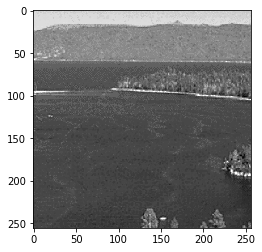

In [12]:
plt.imshow(ytrain_aux[56, :, :, 0], cmap='gray')

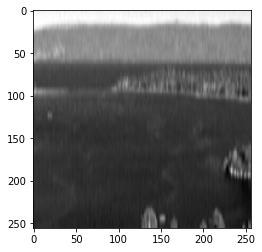

In [13]:
plt.imshow(xtrain_aux[56, :, :, 0], cmap='gray')

In [14]:
# Loading data for testing
# Images degraded by sigma = 3 and filter dimension = (14, 2) (gaussian blur)

xtest_aux = np.zeros((num_test, 256, 256, 1)) # array with degraded images for testing
ytest_aux = np.zeros((num_test, 256, 256, 1)) # array with non-degraded images for testing

for i in range (num_test):
    xtest_aux[i, :, :, 0] = np.load('dataset196_gray/sigma3(14, 2)/arrays/' + str(i+1+num_test) + '.npy')
    ytest_aux[i, :, :, 0] = np.load('dataset196_gray/original/arrays/' + str(i+1+num_test) + '.npy')

In [15]:
# Normalizing data
xtest_aux = xtest_aux/(xtest_aux.max())
ytest_aux = ytest_aux/(ytest_aux.max())

In [16]:
# Range of data: -1 to 1
xtest = 2*xtest_aux - 1
ytest = 2*ytest_aux - 1

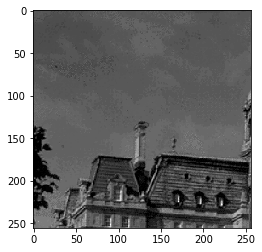

In [17]:
plt.imshow(ytest_aux[4, :, :, 0], cmap='gray')

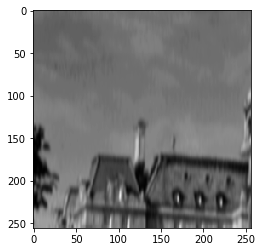

In [18]:
plt.imshow(xtest_aux[4, :, :, 0], cmap='gray')

In [19]:
# Network model
def make_autoencoder(input_shape):
  
    X_input = Input(input_shape)

    X = Conv2D(1, (14, 2), padding="same")(X_input)
    X0 = Activation('tanh')(X)
    X = BatchNormalization()(X0)
    
    X = Conv2D(4, (14, 2), padding="same")(X)
    X1 = Activation('tanh')(X)
    X = BatchNormalization()(X1)
    
    X = Conv2D(8, (14, 2), padding="same")(X)
    X2 = Activation('tanh')(X)
    X = BatchNormalization()(X2)
    
    X = Conv2D(16, (14, 2), padding="same")(X)
    X3 = Activation('tanh')(X)
    X = BatchNormalization()(X3)
 
    # Latent space
    
    X = Conv2DTranspose(8, (14, 2), padding="same")(X)
    X = Activation('tanh')(X)
    X = BatchNormalization()(X)
    X = Add()([X2, X])
    
    X = Conv2DTranspose(4, (14, 2), padding="same")(X)
    X = Activation('tanh')(X)
    X = BatchNormalization()(X)
    X = Add()([X1, X])
    
    X = Conv2DTranspose(1, (14, 2), padding="same")(X)
    X = Activation('tanh')(X)
    X = BatchNormalization()(X)
    X = Add()([X0, X])
    
    X = Conv2DTranspose(1, (14, 2), padding="same")(X)
    X = Activation('tanh')(X)
    

    model = Model(inputs=X_input, outputs=X)
    
    return model

In [20]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


In [21]:
opt = Adam(lr=1e-4)

In [22]:
# Training with 2 GPUs
with mirrored_strategy.scope():
    model = make_autoencoder(ytrain.shape[1:])
    model.compile(optimizer=opt, loss=custom_ssim)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 1)  29          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 1)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 1)  4           activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
history = model.fit(x=xtrain, y=ytrain, epochs=10000, validation_data=[xtest, ytest])

dict_keys(['loss', 'val_loss'])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


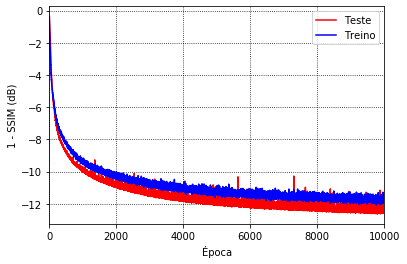

In [25]:
# Plotting loss
plt.plot(10*np.log10(history.history['val_loss']), 'r', label='Teste')
plt.plot(10*np.log10(history.history['loss']), 'b', label='Treino')
plt.legend(loc='upper right')
plt.xlim(0, 10000)
plt.grid(color='black', linestyle='dotted')
plt.ylabel('1 - SSIM (dB)')
plt.xlabel('Época')
plt.savefig('saved/residual_ssim_gray_sigma3_(14, 2)/error.eps', format='eps')
plt.show()

In [29]:
# Saving model
model.save('saved/residual_ssim_sigma3_(14, 2)/model.h5')